In [109]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import csv
import seaborn as sns
from sklearn.model_selection import train_test_split

In [97]:
os.chdir("C:/Users/potapenk/Desktop/Workings/data_science/projects/sign_language/")


extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
DataSet_merged = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
DataSet_merged.to_csv( "DataSet_merged.csv", index=False, encoding='utf-8-sig')


dataset_test = pd.read_csv('C:/Users\potapenk\Desktop\Workings\data_science\projects\sign_language\sign_mnist_test.csv')
dataset_train = pd.read_csv('C:/Users\potapenk\Desktop\Workings\data_science\projects\sign_language\sign_mnist_train.csv')
dataset_merged = pd.read_csv('C:/Users\potapenk\Desktop\Workings\data_science\projects\sign_language\DataSet_merged.csv')

print(len(dataset_merged))
print(len(dataset_test))
print(len(dataset_train))


34627
7172
27455


In [87]:
# class Image:
#     def random_image (self):
#         image = np.array(dataset[:,1:]).random.choise(size=1, replace=False).reshape(28,28)
#         print(plt.imshow(image))

In [110]:
def get_data(filename):
    with open(filename) as training_file:
        reader = csv.reader(training_file, delimiter=',')    
        imgs = []
        labels = []

        next(reader, None)
        
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

        images = np.array(imgs).astype(float)
        labels = np.array(labels).astype(float)
        
    return images, labels

In [111]:
path_sign_data = f"C:/Users\potapenk\Desktop\Workings\data_science\projects\sign_language\DataSet_merged.csv"
images, labels = get_data(path_sign_data)

print(images.shape)
print(labels.shape)

(34627, 28, 28)
(34627,)


<AxesSubplot:ylabel='count'>

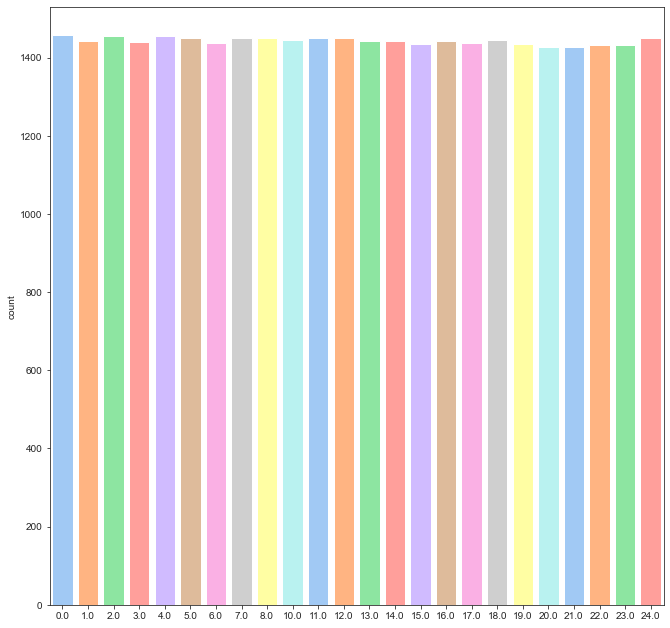

In [100]:
#Show unique labels as pictures and assign letters

plt.figure(figsize = (11,11))
sns.set_style("ticks")
sns.countplot(labels, palette="pastel", saturation=1)

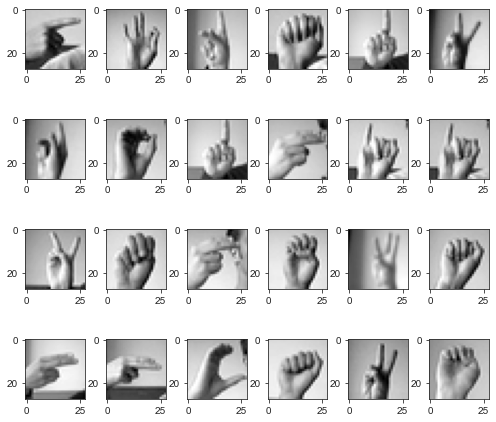

In [112]:
v, h = plt.subplots(4,6) 
v.set_size_inches(7, 7)
k = 0
for i in range(4):
    for j in range(6):
        h[i,j].imshow(images[k], cmap = "gray")
        k += 1
    plt.tight_layout(w_pad=0.2, h_pad=0.2)   

In [113]:
from sklearn.preprocessing import LabelBinarizer
LB = LabelBinarizer()
labels = LB.fit_transform(labels)
labels.shape

(34627, 24)

In [192]:
#Train / Test split

train_images, test_images, train_labels, test_labels = train_test_split( images, labels, test_size=0.20, random_state=4)
print ('Train set:', train_images.shape,  train_labels.shape)
print ('Test set:', test_images.shape,  test_labels.shape)

Train set: (27701, 28, 28) (27701, 24)
Test set: (6926, 28, 28) (6926, 24)


In [193]:
# Padding (adding one additional dimension)

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

max_value = np.ndarray.max(images).astype(float)

# Creating an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rescale = 1./max_value,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/max_value)


train_generator = train_datagen.flow(
    train_images,
    train_labels,
    #target_size=(28,28),
    #class_mode='categorical',
    #batch_size=24
    )

validation_generator = validation_datagen.flow(
    test_images,
    test_labels,
    #target_size=(28,28),
    #class_mode='categorical',
    #batch_size=24
    #steps_per_epoch = len(training_images)/32, 
    #epoch=2
    )
    
print(train_images.shape)
print(test_images.shape)

(27701, 28, 28, 1)
(6926, 28, 28, 1)


In [194]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.980):
                print("\nReached 98.0% accuracy so cancelling training!")
                self.model.stop_training = True
    
callbacks = myCallback()

In [199]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')
])


model.summary()

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator, epochs=200, steps_per_epoch=100, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=[callbacks])

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_93 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 512)             

Epoch 48/200
100/100 [==============================] - 4s 44ms/step - loss: 0.9062 - accuracy: 0.7113 - val_loss: 0.2966 - val_accuracy: 0.9167
Epoch 49/200
100/100 [==============================] - 4s 41ms/step - loss: 0.8759 - accuracy: 0.7184 - val_loss: 0.3357 - val_accuracy: 0.8646
Epoch 50/200
100/100 [==============================] - 5s 47ms/step - loss: 0.8890 - accuracy: 0.7041 - val_loss: 0.2740 - val_accuracy: 0.8854
Epoch 51/200
100/100 [==============================] - 5s 50ms/step - loss: 0.8721 - accuracy: 0.7225 - val_loss: 0.1826 - val_accuracy: 0.9583
Epoch 52/200
100/100 [==============================] - 5s 47ms/step - loss: 0.9128 - accuracy: 0.6931 - val_loss: 0.2646 - val_accuracy: 0.8750
Epoch 53/200
100/100 [==============================] - 4s 42ms/step - loss: 0.8142 - accuracy: 0.7319 - val_loss: 0.2990 - val_accuracy: 0.9167
Epoch 54/200
100/100 [==============================] - 5s 46ms/step - loss: 0.8613 - accuracy: 0.7025 - val_loss: 0.3039 - val_ac

100/100 [==============================] - 4s 36ms/step - loss: 0.5984 - accuracy: 0.8037 - val_loss: 0.0914 - val_accuracy: 0.9792
Epoch 105/200
100/100 [==============================] - 4s 41ms/step - loss: 0.5933 - accuracy: 0.8053 - val_loss: 0.0957 - val_accuracy: 0.9688
Epoch 106/200
100/100 [==============================] - 4s 42ms/step - loss: 0.5838 - accuracy: 0.8084 - val_loss: 0.1055 - val_accuracy: 0.9896
Epoch 107/200
100/100 [==============================] - 5s 45ms/step - loss: 0.6116 - accuracy: 0.8025 - val_loss: 0.1013 - val_accuracy: 0.9688
Epoch 108/200
100/100 [==============================] - 4s 41ms/step - loss: 0.5719 - accuracy: 0.8147 - val_loss: 0.0919 - val_accuracy: 0.9375
Epoch 109/200
100/100 [==============================] - 5s 45ms/step - loss: 0.5713 - accuracy: 0.8144 - val_loss: 0.0761 - val_accuracy: 0.9792
Epoch 110/200
100/100 [==============================] - 4s 40ms/step - loss: 0.5803 - accuracy: 0.8125 - val_loss: 0.1221 - val_accuracy:

100/100 [==============================] - 5s 47ms/step - loss: 0.5250 - accuracy: 0.8306 - val_loss: 0.1127 - val_accuracy: 0.9792
Epoch 161/200
100/100 [==============================] - 4s 41ms/step - loss: 0.4905 - accuracy: 0.8453 - val_loss: 0.0516 - val_accuracy: 0.9792
Epoch 162/200
100/100 [==============================] - 4s 42ms/step - loss: 0.5079 - accuracy: 0.8291 - val_loss: 0.1084 - val_accuracy: 0.9583
Epoch 163/200
100/100 [==============================] - 4s 42ms/step - loss: 0.4800 - accuracy: 0.8450 - val_loss: 0.0480 - val_accuracy: 0.9896
Epoch 164/200
100/100 [==============================] - 4s 44ms/step - loss: 0.4461 - accuracy: 0.8516 - val_loss: 0.0596 - val_accuracy: 0.9792
Epoch 165/200
100/100 [==============================] - 4s 42ms/step - loss: 0.5177 - accuracy: 0.8322 - val_loss: 0.1709 - val_accuracy: 0.9375
Epoch 166/200
100/100 [==============================] - 4s 45ms/step - loss: 0.4885 - accuracy: 0.8400 - val_loss: 0.0610 - val_accuracy:

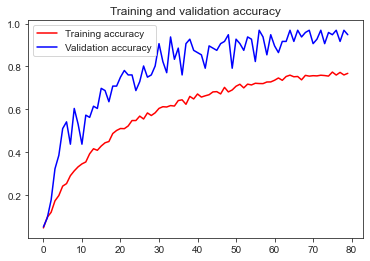

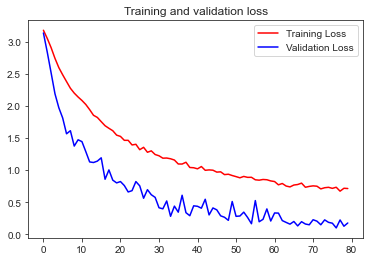

In [198]:
# Plot the chart for accuracy and loss on both training and validation

acc = history.history['accuracy']# Your Code Here
val_acc = history.history['val_accuracy']# Your Code Here
loss = history.history['loss']# Your Code Here
val_loss = history.history['val_loss']# Your Code Here

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()